In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 1:58 - loss: 0.1688 - STD: 2.3266e-04 - MAE: 0.3993

 4/80 [>.............................] - ETA: 2s - loss: 0.0574 - STD: 4.5634e-04 - MAE: 0.1848  

 5/80 [>.............................] - ETA: 2s - loss: 0.0495 - STD: 4.0935e-04 - MAE: 0.1679

 6/80 [=>............................] - ETA: 2s - loss: 0.0448 - STD: 3.6448e-04 - MAE: 0.1592

 7/80 [=>............................] - ETA: 3s - loss: 0.0418 - STD: 3.2582e-04 - MAE: 0.1541

 8/80 [==>...........................] - ETA: 3s - loss: 0.0398 - STD: 2.9336e-04 - MAE: 0.1511

 9/80 [==>...........................] - ETA: 3s - loss: 0.0383 - STD: 2.6616e-04 - MAE: 0.1491

10/80 [==>...........................] - ETA: 3s - loss: 0.0371 - STD: 2.4321e-04 - MAE: 0.1475

11/80 [===>..........................] - ETA: 3s - loss: 0.0362 - STD: 2.2371e-04 - MAE: 0.1464

12/80 [===>..........................] - ETA: 3s - loss: 0.0354 - STD: 2.0698e-04 - MAE: 0.1451

13/80 [===>..........................] - ETA: 3s - loss: 0.0346 - STD: 1.9255e-04 - MAE: 0.1440

14/80 [====>.........................] - ETA: 3s - loss: 0.0339 - STD: 1.8003e-04 - MAE: 0.1428

15/80 [====>.........................] - ETA: 3s - loss: 0.0332 - STD: 1.6917e-04 - MAE: 0.1414

16/80 [=====>........................] - ETA: 3s - loss: 0.0326 - STD: 1.5979e-04 - MAE: 0.1399

17/80 [=====>........................] - ETA: 3s - loss: 0.0318 - STD: 1.5170e-04 - MAE: 0.1381

18/80 [=====>........................] - ETA: 3s - loss: 0.0311 - STD: 1.4474e-04 - MAE: 0.1362

19/80 [======>.......................] - ETA: 3s - loss: 0.0303 - STD: 1.3873e-04 - MAE: 0.1340

20/80 [======>.......................] - ETA: 3s - loss: 0.0295 - STD: 1.3351e-04 - MAE: 0.1318

21/80 [======>.......................] - ETA: 3s - loss: 0.0287 - STD: 1.2895e-04 - MAE: 0.1294

22/80 [=======>......................] - ETA: 3s - loss: 0.0279 - STD: 1.2489e-04 - MAE: 0.1270

23/80 [=======>......................] - ETA: 3s - loss: 0.0271 - STD: 1.2123e-04 - MAE: 0.1248

24/80 [========>.....................] - ETA: 2s - loss: 0.0264 - STD: 1.1785e-04 - MAE: 0.1226

25/80 [========>.....................] - ETA: 2s - loss: 0.0257 - STD: 1.1472e-04 - MAE: 0.1207

26/80 [========>.....................] - ETA: 2s - loss: 0.0251 - STD: 1.1178e-04 - MAE: 0.1191

27/80 [=========>....................] - ETA: 2s - loss: 0.0245 - STD: 1.0898e-04 - MAE: 0.1178

28/80 [=========>....................] - ETA: 2s - loss: 0.0241 - STD: 1.0631e-04 - MAE: 0.1167

29/80 [=========>....................] - ETA: 2s - loss: 0.0236 - STD: 1.0374e-04 - MAE: 0.1158

30/80 [==========>...................] - ETA: 2s - loss: 0.0232 - STD: 1.0125e-04 - MAE: 0.1151

31/80 [==========>...................] - ETA: 2s - loss: 0.0229 - STD: 9.8843e-05 - MAE: 0.1143

32/80 [===========>..................] - ETA: 2s - loss: 0.0225 - STD: 9.6496e-05 - MAE: 0.1136

33/80 [===========>..................] - ETA: 2s - loss: 0.0221 - STD: 9.4207e-05 - MAE: 0.1128

34/80 [===========>..................] - ETA: 2s - loss: 0.0218 - STD: 9.2003e-05 - MAE: 0.1119

35/80 [============>.................] - ETA: 2s - loss: 0.0214 - STD: 8.9873e-05 - MAE: 0.1110

36/80 [============>.................] - ETA: 2s - loss: 0.0211 - STD: 8.7838e-05 - MAE: 0.1101

37/80 [============>.................] - ETA: 2s - loss: 0.0208 - STD: 8.5908e-05 - MAE: 0.1091

38/80 [=============>................] - ETA: 2s - loss: 0.0205 - STD: 8.4068e-05 - MAE: 0.1083

39/80 [=============>................] - ETA: 2s - loss: 0.0202 - STD: 8.2321e-05 - MAE: 0.1074

40/80 [==============>...............] - ETA: 2s - loss: 0.0199 - STD: 8.0667e-05 - MAE: 0.1065

41/80 [==============>...............] - ETA: 2s - loss: 0.0197 - STD: 7.9102e-05 - MAE: 0.1057

42/80 [==============>...............] - ETA: 2s - loss: 0.0194 - STD: 7.7617e-05 - MAE: 0.1050

43/80 [===============>..............] - ETA: 2s - loss: 0.0192 - STD: 7.6204e-05 - MAE: 0.1043

44/80 [===============>..............] - ETA: 1s - loss: 0.0190 - STD: 7.4865e-05 - MAE: 0.1036

45/80 [===============>..............] - ETA: 1s - loss: 0.0188 - STD: 7.3599e-05 - MAE: 0.1030

46/80 [================>.............] - ETA: 1s - loss: 0.0186 - STD: 7.2386e-05 - MAE: 0.1023

47/80 [================>.............] - ETA: 1s - loss: 0.0184 - STD: 7.1237e-05 - MAE: 0.1017

48/80 [=================>............] - ETA: 1s - loss: 0.0182 - STD: 7.0146e-05 - MAE: 0.1012

49/80 [=================>............] - ETA: 1s - loss: 0.0180 - STD: 6.9106e-05 - MAE: 0.1006

50/80 [=================>............] - ETA: 1s - loss: 0.0179 - STD: 6.8122e-05 - MAE: 0.1001

51/80 [==================>...........] - ETA: 1s - loss: 0.0177 - STD: 6.7180e-05 - MAE: 0.0996

52/80 [==================>...........] - ETA: 1s - loss: 0.0175 - STD: 6.6295e-05 - MAE: 0.0991

53/80 [==================>...........] - ETA: 1s - loss: 0.0174 - STD: 6.5443e-05 - MAE: 0.0987

54/80 [===================>..........] - ETA: 1s - loss: 0.0172 - STD: 6.4638e-05 - MAE: 0.0983

55/80 [===================>..........] - ETA: 1s - loss: 0.0171 - STD: 6.3871e-05 - MAE: 0.0979

56/80 [====================>.........] - ETA: 1s - loss: 0.0170 - STD: 6.3138e-05 - MAE: 0.0975

57/80 [====================>.........] - ETA: 1s - loss: 0.0168 - STD: 6.2440e-05 - MAE: 0.0972

58/80 [====================>.........] - ETA: 1s - loss: 0.0167 - STD: 6.1772e-05 - MAE: 0.0969

59/80 [=====================>........] - ETA: 1s - loss: 0.0166 - STD: 6.1133e-05 - MAE: 0.0966

60/80 [=====================>........] - ETA: 1s - loss: 0.0165 - STD: 6.0524e-05 - MAE: 0.0962

61/80 [=====================>........] - ETA: 1s - loss: 0.0163 - STD: 5.9945e-05 - MAE: 0.0959

62/80 [======================>.......] - ETA: 1s - loss: 0.0162 - STD: 5.9394e-05 - MAE: 0.0956

63/80 [======================>.......] - ETA: 0s - loss: 0.0161 - STD: 5.8865e-05 - MAE: 0.0953

64/80 [=======================>......] - ETA: 0s - loss: 0.0160 - STD: 5.8355e-05 - MAE: 0.0950

65/80 [=======================>......] - ETA: 0s - loss: 0.0160 - STD: 5.7865e-05 - MAE: 0.0947

68/80 [========================>.....] - ETA: 0s - loss: 0.0157 - STD: 5.6537e-05 - MAE: 0.0938

70/80 [=========================>....] - ETA: 0s - loss: 0.0155 - STD: 5.5745e-05 - MAE: 0.0932

71/80 [=========================>....] - ETA: 0s - loss: 0.0154 - STD: 5.5379e-05 - MAE: 0.0930

72/80 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 5.5033e-05 - MAE: 0.0927

73/80 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 5.4701e-05 - MAE: 0.0925

74/80 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 5.4387e-05 - MAE: 0.0923

75/80 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 5.4093e-05 - MAE: 0.0920

76/80 [===========================>..] - ETA: 0s - loss: 0.0150 - STD: 5.3816e-05 - MAE: 0.0918

77/80 [===========================>..] - ETA: 0s - loss: 0.0149 - STD: 5.3553e-05 - MAE: 0.0916

78/80 [============================>.] - ETA: 0s - loss: 0.0148 - STD: 5.3304e-05 - MAE: 0.0914

79/80 [============================>.] - ETA: 0s - loss: 0.0148 - STD: 5.3075e-05 - MAE: 0.0912

80/80 [==============================] - ETA: 0s - loss: 0.0147 - STD: 5.2859e-05 - MAE: 0.0910

80/80 [==============================] - 7s 71ms/step - loss: 0.0147 - STD: 5.2859e-05 - MAE: 0.0910 - val_loss: 0.0086 - val_STD: 2.4648e-05 - val_MAE: 0.0720


Epoch 2/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0092 - STD: 3.6846e-05 - MAE: 0.0762

 2/80 [..............................] - ETA: 4s - loss: 0.0093 - STD: 3.7204e-05 - MAE: 0.0765

 3/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 3.7391e-05 - MAE: 0.0760

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 3.7716e-05 - MAE: 0.0761

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 3.8049e-05 - MAE: 0.0760

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 3.8451e-05 - MAE: 0.0761

 7/80 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 3.8825e-05 - MAE: 0.0763

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.9210e-05 - MAE: 0.0761

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.9534e-05 - MAE: 0.0760

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.9911e-05 - MAE: 0.0759

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.0246e-05 - MAE: 0.0758

12/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.0606e-05 - MAE: 0.0757

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 4.0981e-05 - MAE: 0.0756

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 4.1371e-05 - MAE: 0.0755

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 4.1754e-05 - MAE: 0.0754

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.2157e-05 - MAE: 0.0754

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.2527e-05 - MAE: 0.0754

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 4.2948e-05 - MAE: 0.0754

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 4.3382e-05 - MAE: 0.0755

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 4.3797e-05 - MAE: 0.0754

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 4.4213e-05 - MAE: 0.0754

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 4.4693e-05 - MAE: 0.0754

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 4.5180e-05 - MAE: 0.0754

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 4.5656e-05 - MAE: 0.0754

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 4.6133e-05 - MAE: 0.0755

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 4.6659e-05 - MAE: 0.0755

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 4.7177e-05 - MAE: 0.0756

28/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 4.7701e-05 - MAE: 0.0756

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 4.8197e-05 - MAE: 0.0756

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.8733e-05 - MAE: 0.0756

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.9249e-05 - MAE: 0.0756

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.9798e-05 - MAE: 0.0756

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.0334e-05 - MAE: 0.0755

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.0882e-05 - MAE: 0.0755

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.1428e-05 - MAE: 0.0755

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.1990e-05 - MAE: 0.0755

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.2574e-05 - MAE: 0.0755

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 5.3170e-05 - MAE: 0.0755

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.4346e-05 - MAE: 0.0755

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.4973e-05 - MAE: 0.0755

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.5599e-05 - MAE: 0.0755

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.6248e-05 - MAE: 0.0755

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.6903e-05 - MAE: 0.0755

45/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.7569e-05 - MAE: 0.0755

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.8257e-05 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 5.8964e-05 - MAE: 0.0754

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.9667e-05 - MAE: 0.0754

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.0379e-05 - MAE: 0.0754

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.1107e-05 - MAE: 0.0754

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.1858e-05 - MAE: 0.0754

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.2622e-05 - MAE: 0.0754

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 6.3386e-05 - MAE: 0.0754

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.4208e-05 - MAE: 0.0754

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 6.5015e-05 - MAE: 0.0754

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.5837e-05 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.6686e-05 - MAE: 0.0754

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.7559e-05 - MAE: 0.0754

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.8425e-05 - MAE: 0.0754

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.9299e-05 - MAE: 0.0754

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 7.0211e-05 - MAE: 0.0754

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 7.1137e-05 - MAE: 0.0754

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.2110e-05 - MAE: 0.0754

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.3086e-05 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.4087e-05 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 7.5115e-05 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.6183e-05 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.7253e-05 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 7.8336e-05 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.9466e-05 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 8.0595e-05 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.1767e-05 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.2951e-05 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 8.4135e-05 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.5345e-05 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.6602e-05 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.7911e-05 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 8.9240e-05 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 9.0614e-05 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 9.2005e-05 - MAE: 0.0754

80/80 [==============================] - 5s 62ms/step - loss: 0.0092 - STD: 9.2005e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.4041e-04 - val_MAE: 0.0715


Epoch 3/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0093 - STD: 2.0726e-04 - MAE: 0.0762

 2/80 [..............................] - ETA: 5s - loss: 0.0092 - STD: 2.1101e-04 - MAE: 0.0756

 3/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 2.1362e-04 - MAE: 0.0752

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.1691e-04 - MAE: 0.0755

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.1994e-04 - MAE: 0.0755

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2329e-04 - MAE: 0.0755

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2638e-04 - MAE: 0.0755

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 2.2945e-04 - MAE: 0.0755

 9/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 2.3273e-04 - MAE: 0.0755

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 2.3613e-04 - MAE: 0.0755

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 2.3995e-04 - MAE: 0.0755

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4353e-04 - MAE: 0.0754

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4714e-04 - MAE: 0.0754

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.5076e-04 - MAE: 0.0753

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.5435e-04 - MAE: 0.0753

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.5833e-04 - MAE: 0.0753

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6236e-04 - MAE: 0.0753

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6676e-04 - MAE: 0.0753

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7108e-04 - MAE: 0.0752

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7543e-04 - MAE: 0.0752

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.8006e-04 - MAE: 0.0752

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8487e-04 - MAE: 0.0752

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8984e-04 - MAE: 0.0752

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.9499e-04 - MAE: 0.0752

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 3.0043e-04 - MAE: 0.0752

26/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 3.0589e-04 - MAE: 0.0753

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.1140e-04 - MAE: 0.0752

28/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.1717e-04 - MAE: 0.0752

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.2317e-04 - MAE: 0.0753

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.2916e-04 - MAE: 0.0752

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.3549e-04 - MAE: 0.0752

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.4886e-04 - MAE: 0.0752

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.5591e-04 - MAE: 0.0752

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.6301e-04 - MAE: 0.0752

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.7053e-04 - MAE: 0.0752

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.7821e-04 - MAE: 0.0752

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.8614e-04 - MAE: 0.0752

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.9467e-04 - MAE: 0.0752

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.0316e-04 - MAE: 0.0752

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.1225e-04 - MAE: 0.0752

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.2146e-04 - MAE: 0.0752

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 4.3090e-04 - MAE: 0.0752

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 4.4081e-04 - MAE: 0.0752

45/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 4.5109e-04 - MAE: 0.0752

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.6166e-04 - MAE: 0.0752

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.7284e-04 - MAE: 0.0752

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.8419e-04 - MAE: 0.0752

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.9634e-04 - MAE: 0.0752

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.0899e-04 - MAE: 0.0752

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.2177e-04 - MAE: 0.0752

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.3524e-04 - MAE: 0.0752

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.4925e-04 - MAE: 0.0752

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.6370e-04 - MAE: 0.0752

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.7831e-04 - MAE: 0.0752

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.9358e-04 - MAE: 0.0752

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.0942e-04 - MAE: 0.0752

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 6.2592e-04 - MAE: 0.0751

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.4326e-04 - MAE: 0.0752

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.6096e-04 - MAE: 0.0752

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 6.7967e-04 - MAE: 0.0751

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 6.9887e-04 - MAE: 0.0751

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 7.1908e-04 - MAE: 0.0751

64/80 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 7.4007e-04 - MAE: 0.0751

65/80 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 7.6179e-04 - MAE: 0.0751

66/80 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 7.8458e-04 - MAE: 0.0751

67/80 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 8.0821e-04 - MAE: 0.0751

68/80 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 8.3318e-04 - MAE: 0.0751

69/80 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 8.5872e-04 - MAE: 0.0751

70/80 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 8.8529e-04 - MAE: 0.0751

71/80 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 9.1335e-04 - MAE: 0.0751

72/80 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 9.4202e-04 - MAE: 0.0751

73/80 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 9.7231e-04 - MAE: 0.0751

74/80 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

75/80 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

76/80 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

77/80 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

78/80 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0750

79/80 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

80/80 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

80/80 [==============================] - 5s 61ms/step - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750 - val_loss: 0.0082 - val_STD: 0.0030 - val_MAE: 0.0702


Epoch 4/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0087 - STD: 0.0045 - MAE: 0.0738

 2/80 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0047 - MAE: 0.0741

 3/80 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0737

 4/80 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0739

 5/80 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0050 - MAE: 0.0740

 6/80 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0737

 7/80 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0053 - MAE: 0.0739

 8/80 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0740

 9/80 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0739

10/80 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0739

11/80 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0739

12/80 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.0060 - MAE: 0.0739

13/80 [===>..........................] - ETA: 3s - loss: 0.0088 - STD: 0.0061 - MAE: 0.0739

14/80 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.0063 - MAE: 0.0739

15/80 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.0065 - MAE: 0.0739

16/80 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0738

17/80 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0738

18/80 [=====>........................] - ETA: 3s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0737

19/80 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0736

20/80 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0073 - MAE: 0.0736

21/80 [======>.......................] - ETA: 3s - loss: 0.0087 - STD: 0.0075 - MAE: 0.0736

22/80 [=======>......................] - ETA: 3s - loss: 0.0087 - STD: 0.0077 - MAE: 0.0735

23/80 [=======>......................] - ETA: 3s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0735

24/80 [========>.....................] - ETA: 3s - loss: 0.0086 - STD: 0.0081 - MAE: 0.0734

25/80 [========>.....................] - ETA: 3s - loss: 0.0086 - STD: 0.0083 - MAE: 0.0733

26/80 [========>.....................] - ETA: 3s - loss: 0.0086 - STD: 0.0085 - MAE: 0.0733

27/80 [=========>....................] - ETA: 3s - loss: 0.0086 - STD: 0.0087 - MAE: 0.0732

28/80 [=========>....................] - ETA: 3s - loss: 0.0086 - STD: 0.0090 - MAE: 0.0732

29/80 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0092 - MAE: 0.0731

30/80 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.0094 - MAE: 0.0730

31/80 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.0096 - MAE: 0.0730

32/80 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0099 - MAE: 0.0729

33/80 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0101 - MAE: 0.0728

34/80 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0104 - MAE: 0.0728

35/80 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0106 - MAE: 0.0727

36/80 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0109 - MAE: 0.0727

37/80 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.0111 - MAE: 0.0726

38/80 [=============>................] - ETA: 2s - loss: 0.0084 - STD: 0.0114 - MAE: 0.0725

39/80 [=============>................] - ETA: 2s - loss: 0.0084 - STD: 0.0116 - MAE: 0.0725

40/80 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0119 - MAE: 0.0724

41/80 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0122 - MAE: 0.0723

42/80 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0125 - MAE: 0.0723

43/80 [===============>..............] - ETA: 2s - loss: 0.0083 - STD: 0.0127 - MAE: 0.0722

45/80 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0720

46/80 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0136 - MAE: 0.0720

47/80 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0139 - MAE: 0.0719

48/80 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0142 - MAE: 0.0718

49/80 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0145 - MAE: 0.0718

50/80 [=================>............] - ETA: 1s - loss: 0.0082 - STD: 0.0148 - MAE: 0.0717

51/80 [==================>...........] - ETA: 1s - loss: 0.0082 - STD: 0.0150 - MAE: 0.0716

52/80 [==================>...........] - ETA: 1s - loss: 0.0082 - STD: 0.0153 - MAE: 0.0716

53/80 [==================>...........] - ETA: 1s - loss: 0.0082 - STD: 0.0156 - MAE: 0.0716

54/80 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0159 - MAE: 0.0715

55/80 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.0162 - MAE: 0.0714

56/80 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0164 - MAE: 0.0714

57/80 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0167 - MAE: 0.0713

58/80 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.0170 - MAE: 0.0713

59/80 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0173 - MAE: 0.0712

60/80 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0175 - MAE: 0.0711

61/80 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0178 - MAE: 0.0711

62/80 [======================>.......] - ETA: 1s - loss: 0.0081 - STD: 0.0181 - MAE: 0.0710

63/80 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0184 - MAE: 0.0710

64/80 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0186 - MAE: 0.0709

65/80 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0189 - MAE: 0.0709

66/80 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.0192 - MAE: 0.0708

67/80 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0194 - MAE: 0.0708

68/80 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0197 - MAE: 0.0707

69/80 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0200 - MAE: 0.0706

70/80 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0202 - MAE: 0.0706

71/80 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.0204 - MAE: 0.0705

72/80 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0207 - MAE: 0.0705

73/80 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0209 - MAE: 0.0704

74/80 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0211 - MAE: 0.0704

75/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0214 - MAE: 0.0703

76/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0216 - MAE: 0.0702

77/80 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0218 - MAE: 0.0702

78/80 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0220 - MAE: 0.0701

79/80 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.0222 - MAE: 0.0701

80/80 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.0224 - MAE: 0.0700

80/80 [==============================] - 5s 61ms/step - loss: 0.0079 - STD: 0.0224 - MAE: 0.0700 - val_loss: 0.0066 - val_STD: 0.0250 - val_MAE: 0.0614


Epoch 5/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0072 - STD: 0.0382 - MAE: 0.0660

 2/80 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0384 - MAE: 0.0655

 3/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0385 - MAE: 0.0654

 4/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0384 - MAE: 0.0651

 5/80 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0384 - MAE: 0.0652

 6/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0385 - MAE: 0.0653

 7/80 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0385 - MAE: 0.0653

 8/80 [==>...........................] - ETA: 4s - loss: 0.0070 - STD: 0.0385 - MAE: 0.0653

 9/80 [==>...........................] - ETA: 4s - loss: 0.0070 - STD: 0.0385 - MAE: 0.0653

10/80 [==>...........................] - ETA: 4s - loss: 0.0070 - STD: 0.0385 - MAE: 0.0653

11/80 [===>..........................] - ETA: 4s - loss: 0.0070 - STD: 0.0386 - MAE: 0.0652

12/80 [===>..........................] - ETA: 4s - loss: 0.0070 - STD: 0.0386 - MAE: 0.0652

13/80 [===>..........................] - ETA: 3s - loss: 0.0070 - STD: 0.0387 - MAE: 0.0652

14/80 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0388 - MAE: 0.0652

15/80 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0389 - MAE: 0.0653

16/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0390 - MAE: 0.0653

17/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0391 - MAE: 0.0653

18/80 [=====>........................] - ETA: 3s - loss: 0.0070 - STD: 0.0391 - MAE: 0.0653

19/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0392 - MAE: 0.0653

20/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0393 - MAE: 0.0652

21/80 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0394 - MAE: 0.0653

22/80 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0394 - MAE: 0.0653

23/80 [=======>......................] - ETA: 3s - loss: 0.0070 - STD: 0.0395 - MAE: 0.0652

24/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0396 - MAE: 0.0651

25/80 [========>.....................] - ETA: 3s - loss: 0.0070 - STD: 0.0396 - MAE: 0.0650

26/80 [========>.....................] - ETA: 3s - loss: 0.0069 - STD: 0.0397 - MAE: 0.0650

27/80 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0397 - MAE: 0.0649

28/80 [=========>....................] - ETA: 3s - loss: 0.0069 - STD: 0.0398 - MAE: 0.0649

29/80 [=========>....................] - ETA: 2s - loss: 0.0069 - STD: 0.0399 - MAE: 0.0648

30/80 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0399 - MAE: 0.0648

31/80 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0400 - MAE: 0.0647

32/80 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0401 - MAE: 0.0647

33/80 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0401 - MAE: 0.0646

34/80 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0402 - MAE: 0.0646

35/80 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0403 - MAE: 0.0645

36/80 [============>.................] - ETA: 2s - loss: 0.0068 - STD: 0.0404 - MAE: 0.0644

37/80 [============>.................] - ETA: 2s - loss: 0.0068 - STD: 0.0405 - MAE: 0.0644

38/80 [=============>................] - ETA: 2s - loss: 0.0068 - STD: 0.0406 - MAE: 0.0643

40/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0408 - MAE: 0.0642

41/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0408 - MAE: 0.0640

42/80 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0409 - MAE: 0.0640

43/80 [===============>..............] - ETA: 2s - loss: 0.0068 - STD: 0.0410 - MAE: 0.0639

44/80 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.0410 - MAE: 0.0638

45/80 [===============>..............] - ETA: 2s - loss: 0.0067 - STD: 0.0411 - MAE: 0.0637

46/80 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0412 - MAE: 0.0637

47/80 [================>.............] - ETA: 1s - loss: 0.0067 - STD: 0.0413 - MAE: 0.0636

48/80 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0414 - MAE: 0.0635

49/80 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0416 - MAE: 0.0634

50/80 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0416 - MAE: 0.0633

51/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0418 - MAE: 0.0633

52/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0420 - MAE: 0.0632

53/80 [==================>...........] - ETA: 1s - loss: 0.0066 - STD: 0.0420 - MAE: 0.0631

54/80 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0422 - MAE: 0.0630

55/80 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0424 - MAE: 0.0630

56/80 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0425 - MAE: 0.0629

57/80 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0427 - MAE: 0.0628

58/80 [====================>.........] - ETA: 1s - loss: 0.0065 - STD: 0.0429 - MAE: 0.0627

59/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0430 - MAE: 0.0626

60/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0432 - MAE: 0.0626

61/80 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0434 - MAE: 0.0625

62/80 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0435 - MAE: 0.0625

63/80 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0436 - MAE: 0.0623

64/80 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0438 - MAE: 0.0623

65/80 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0440 - MAE: 0.0622

66/80 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0441 - MAE: 0.0621

67/80 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0443 - MAE: 0.0620

68/80 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0445 - MAE: 0.0620

69/80 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0446 - MAE: 0.0619

70/80 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0448 - MAE: 0.0618

71/80 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0450 - MAE: 0.0617

72/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0451 - MAE: 0.0616

73/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0453 - MAE: 0.0616

74/80 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0455 - MAE: 0.0615

75/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0456 - MAE: 0.0614

76/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0458 - MAE: 0.0614

77/80 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0460 - MAE: 0.0613

78/80 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0461 - MAE: 0.0612

79/80 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0462 - MAE: 0.0612

80/80 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0464 - MAE: 0.0611

80/80 [==============================] - 5s 61ms/step - loss: 0.0063 - STD: 0.0464 - MAE: 0.0611 - val_loss: 0.0052 - val_STD: 0.0401 - val_MAE: 0.0524


Epoch 6/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0528 - MAE: 0.0545

 2/80 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0558 - MAE: 0.0557

 3/80 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0570 - MAE: 0.0558

 4/80 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0557 - MAE: 0.0556

 5/80 [>.............................] - ETA: 4s - loss: 0.0054 - STD: 0.0563 - MAE: 0.0558

 6/80 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0561

 7/80 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0557

 8/80 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0556

 9/80 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0560

10/80 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0558

11/80 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0556

12/80 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0558

13/80 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0574 - MAE: 0.0557

14/80 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0573 - MAE: 0.0556

15/80 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0558

16/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0556

17/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0555

18/80 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0554

19/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0554

20/80 [======>.......................] - ETA: 3s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0553

22/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0552

23/80 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0551

24/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0583 - MAE: 0.0551

25/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0551

26/80 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0550

27/80 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0584 - MAE: 0.0549

28/80 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0549

29/80 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0548

30/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0547

31/80 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0547

32/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0546

33/80 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0546

34/80 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0591 - MAE: 0.0545

35/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0545

36/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0544

37/80 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0544

38/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0543

39/80 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0543

40/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0543

41/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0542

42/80 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0595 - MAE: 0.0542

43/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

44/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0541

45/80 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

46/80 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0541

47/80 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

48/80 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0541

49/80 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0541

50/80 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

51/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

52/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0542

53/80 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

54/80 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0542

55/80 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0543

56/80 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0543

57/80 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0542

58/80 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0542

59/80 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

60/80 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

61/80 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0542

62/80 [======================>.......] - ETA: 1s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0541

63/80 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0542

64/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

65/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0596 - MAE: 0.0541

66/80 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

67/80 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0541

68/80 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0540

69/80 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0540

70/80 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0540

71/80 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0539

72/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0598 - MAE: 0.0539

73/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0539

74/80 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0600 - MAE: 0.0538

75/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0600 - MAE: 0.0538

76/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0601 - MAE: 0.0538

77/80 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0601 - MAE: 0.0537

78/80 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0602 - MAE: 0.0537

79/80 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0537

80/80 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0536

80/80 [==============================] - 5s 62ms/step - loss: 0.0050 - STD: 0.0603 - MAE: 0.0536 - val_loss: 0.0041 - val_STD: 0.0532 - val_MAE: 0.0473


Epoch 7/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0503

 2/80 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0507

 3/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0508

 4/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0508

 5/80 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0507

 6/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0505

 7/80 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0507

 8/80 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0506

 9/80 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0506

10/80 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0506

11/80 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0505

12/80 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0504

13/80 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0505

14/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0505

15/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0504

17/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0504

18/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0650 - MAE: 0.0504

19/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0504

20/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0505

21/80 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0650 - MAE: 0.0504

22/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0504

23/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0504

24/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0503

25/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0503

26/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0503

27/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0504

28/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0503

29/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0653 - MAE: 0.0504

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0504

31/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0503

32/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0504

33/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0503

34/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0654 - MAE: 0.0503

35/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0503

36/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0503

37/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0502

38/80 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0502

39/80 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0656 - MAE: 0.0502

40/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502

41/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502

42/80 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0502

43/80 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0502

44/80 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0502

45/80 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0502

46/80 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0501

47/80 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0501

48/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0501

49/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0501

50/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0501

51/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0500

52/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0658 - MAE: 0.0500

53/80 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0500

54/80 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0500

55/80 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0500

56/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0659 - MAE: 0.0500

57/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0500

58/80 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0500

59/80 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

60/80 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0499

61/80 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

62/80 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0499

63/80 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

64/80 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0500

65/80 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0499

66/80 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499

67/80 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499

68/80 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499

69/80 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0499

70/80 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0499

71/80 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0499

72/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0499

73/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0498

74/80 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

75/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0498

76/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

77/80 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0498

78/80 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0497

79/80 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0497

80/80 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0497

80/80 [==============================] - 5s 61ms/step - loss: 0.0044 - STD: 0.0663 - MAE: 0.0497 - val_loss: 0.0038 - val_STD: 0.0607 - val_MAE: 0.0467


Epoch 8/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0508

 2/80 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0495

 3/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0489

 4/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

 5/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

 6/80 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

 7/80 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0487

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0485

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0486

10/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0485

11/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0484

12/80 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

13/80 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0483

14/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0483

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0484

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0682 - MAE: 0.0484

17/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

18/80 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0485

19/80 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0486

20/80 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0486

22/80 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

23/80 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0484

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0484

25/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

26/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0484

27/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

28/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0484

29/80 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

30/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0485

31/80 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

32/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

33/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0485

34/80 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

35/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0485

36/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

37/80 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

38/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

39/80 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

40/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

41/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

42/80 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

43/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

44/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

45/80 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0485

46/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

47/80 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0485

48/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0484

49/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0485

50/80 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0484

51/80 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0484

52/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

53/80 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

54/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0484

55/80 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

56/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

57/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

58/80 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

59/80 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

60/80 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0483

61/80 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

62/80 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

63/80 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

64/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

65/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

66/80 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

67/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0481

68/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0481

69/80 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0481

70/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

71/80 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0481

72/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

73/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

74/80 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

75/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

76/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

77/80 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

78/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

79/80 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

80/80 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

80/80 [==============================] - 5s 61ms/step - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481 - val_loss: 0.0038 - val_STD: 0.0555 - val_MAE: 0.0445


Epoch 9/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0040 - STD: 0.0665 - MAE: 0.0469

 2/80 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0493

 3/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0492

 4/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0491

 5/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

 6/80 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0484

 7/80 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

 8/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0484

 9/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

10/80 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0483

11/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0484

12/80 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0483

13/80 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0483

14/80 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0483

15/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0483

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0482

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0483

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0482

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0481

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0481

22/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0481

23/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0480

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0481

25/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0480

26/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

27/80 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

28/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

29/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

30/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

31/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0478

32/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

33/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

34/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0478

35/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

36/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0478

37/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0477

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0477

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0477

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0477

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0476

44/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

45/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

46/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0474

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0473

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0473

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0472

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0472

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0472

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0471

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

77/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

78/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

79/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

80/80 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

80/80 [==============================] - 5s 60ms/step - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471 - val_loss: 0.0035 - val_STD: 0.0589 - val_MAE: 0.0432


Epoch 10/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0454

 2/80 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

 3/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0460

 4/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0461

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

 7/80 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

 8/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

 9/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

10/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

12/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

13/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

14/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

15/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

16/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

17/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

18/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0461

19/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0463

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0464

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0463

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0464

27/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0464

28/80 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0464

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0464

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0464

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0464

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

41/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

42/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

44/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

45/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0465

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

60/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

61/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

62/80 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0464

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0464

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0464

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0463

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

80/80 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463 - val_loss: 0.0033 - val_STD: 0.0613 - val_MAE: 0.0426


Epoch 11/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0457

 3/80 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0454

 4/80 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

 5/80 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

 6/80 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0455

 7/80 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0458

 8/80 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0458

 9/80 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

10/80 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

11/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458

12/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

13/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

14/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

15/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

16/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

17/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

18/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

19/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

26/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

27/80 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

28/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

44/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

45/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

46/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

60/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

62/80 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0457

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0457

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0456

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456

80/80 [==============================] - 5s 60ms/step - loss: 0.0037 - STD: 0.0726 - MAE: 0.0456 - val_loss: 0.0032 - val_STD: 0.0623 - val_MAE: 0.0421


Epoch 12/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0445

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0449

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0451

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0450

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0449

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

28/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

76/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

80/80 [==============================] - 5s 60ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0635 - val_MAE: 0.0424


Epoch 13/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0459

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0453

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

11/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

12/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0444

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

80/80 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0565 - val_MAE: 0.0426


Epoch 14/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0450

 2/80 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0464

 3/80 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0456

 4/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0450

 5/80 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

 6/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0723 - MAE: 0.0451

 7/80 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0451

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0450

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0448

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0449

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0448

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0447

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0447

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0447

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0446

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0446

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0446

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0445

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0445

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0445

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0445

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0445

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0444

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0444

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0444

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

45/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0442

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0442

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

62/80 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0443

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

80/80 [==============================] - 5s 60ms/step - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0571 - val_MAE: 0.0428


Epoch 15/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0686 - MAE: 0.0447

 2/80 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0448

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0444

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0443

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

 8/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 9/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0444

10/80 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0444

11/80 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0443

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0442

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0440

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

27/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

28/80 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

45/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

80/80 [==============================] - 5s 60ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437 - val_loss: 0.0032 - val_STD: 0.0588 - val_MAE: 0.0408


Epoch 16/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0428

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0430

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0434

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0432

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0435

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0435

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

27/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

44/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

80/80 [==============================] - 5s 60ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0402


Epoch 17/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0434

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0437

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0436

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0435

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0436

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0436

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0434

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0434

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

80/80 [==============================] - 5s 60ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0629 - val_MAE: 0.0398


Epoch 18/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0428

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0438

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

 5/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 6/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

 8/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

 9/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

10/80 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

11/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

12/80 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

27/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

28/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

29/80 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

45/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

80/80 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0397


Epoch 19/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0398


Epoch 20/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0428

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0421

 4/80 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0422

 5/80 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 6/80 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 7/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0396


Epoch 21/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0426

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0740 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0430

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

26/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425 - val_loss: 0.0029 - val_STD: 0.0653 - val_MAE: 0.0407


Epoch 22/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0439

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0433

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0428

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0426

11/80 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

45/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

80/80 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0033 - val_STD: 0.0580 - val_MAE: 0.0404


Epoch 23/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0705 - MAE: 0.0422

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0427

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0423

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0744 - MAE: 0.0420

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0421

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

11/80 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0422

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

28/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

80/80 [==============================] - 5s 60ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0603 - val_MAE: 0.0390


Epoch 24/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0413

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0733 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0425

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0425

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0425

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0426

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0427

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0427

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0427

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

44/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

62/80 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0389


Epoch 25/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0388


Epoch 26/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0416

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0417

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0416

11/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

12/80 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0416

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

29/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

80/80 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0398


Epoch 27/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0430

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0420

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0422

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0420

 9/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

10/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0427

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

26/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

27/80 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0649 - val_MAE: 0.0385


Epoch 28/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0798 - MAE: 0.0416

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0802 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0417

 9/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

10/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0640 - val_MAE: 0.0384


Epoch 29/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0757 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0412

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

28/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415 - val_loss: 0.0028 - val_STD: 0.0645 - val_MAE: 0.0384


Epoch 30/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0408

 2/80 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0406

 4/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0413

 5/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 6/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0418

 7/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0420

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413 - val_loss: 0.0028 - val_STD: 0.0650 - val_MAE: 0.0385


Epoch 31/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0414

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

80/80 [==============================] - 5s 58ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411 - val_loss: 0.0028 - val_STD: 0.0667 - val_MAE: 0.0392


Epoch 32/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0425

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

45/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

80/80 [==============================] - 5s 60ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0028 - val_STD: 0.0630 - val_MAE: 0.0381


Epoch 33/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0762 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0410

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0412

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0410

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0409

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410 - val_loss: 0.0028 - val_STD: 0.0654 - val_MAE: 0.0384


Epoch 34/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0416

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0407

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0388


Epoch 35/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0419

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

11/80 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408 - val_loss: 0.0031 - val_STD: 0.0618 - val_MAE: 0.0390


Epoch 36/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0409

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 5/80 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

 6/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 7/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0413

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0033 - val_STD: 0.0596 - val_MAE: 0.0400


Epoch 37/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0729 - MAE: 0.0418

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0418

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0672 - val_MAE: 0.0390


Epoch 38/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0820 - MAE: 0.0408

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

28/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

45/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0686 - val_MAE: 0.0397


Epoch 39/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

80/80 [==============================] - 5s 59ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0677 - val_MAE: 0.0399


Epoch 40/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0407

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0407

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0408

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

62/80 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

80/80 [==============================] - 5s 60ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0683 - val_MAE: 0.0383


Epoch 41/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0839 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0817 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0396

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

80/80 [==============================] - 5s 58ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0378


Epoch 42/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0376


Epoch 43/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0391

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 8/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

62/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - 5s 57ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0638 - val_MAE: 0.0377


Epoch 44/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0767 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0392

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0032 - val_STD: 0.0606 - val_MAE: 0.0393


Epoch 45/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0406

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

 8/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

 9/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0415

10/80 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

27/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

28/80 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

44/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

45/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402 - val_loss: 0.0030 - val_STD: 0.0620 - val_MAE: 0.0382


Epoch 46/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0400

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0400

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0030 - val_STD: 0.0628 - val_MAE: 0.0383


Epoch 47/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0759 - MAE: 0.0395

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0399

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0395

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

26/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

27/80 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

44/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

62/80 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

80/80 [==============================] - 5s 60ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0682 - val_MAE: 0.0384


Epoch 48/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0816 - MAE: 0.0407

 2/80 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

80/80 [==============================] - 5s 59ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0029 - val_STD: 0.0625 - val_MAE: 0.0379


Epoch 49/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0397

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0671 - val_MAE: 0.0382


Epoch 50/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0389

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0374


Epoch 51/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0398

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0398

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

10/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0399

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

27/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

28/80 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

45/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395 - val_loss: 0.0029 - val_STD: 0.0692 - val_MAE: 0.0395


Epoch 52/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0412

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0403

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

 8/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

 9/80 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0401

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0400

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0399

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0373


Epoch 53/10000


 1/80 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0809 - MAE: 0.0385

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0812 - MAE: 0.0385

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0386

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 8/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 9/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

10/80 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

11/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

25/80 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

26/80 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

27/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

80/80 [==============================] - 5s 58ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0665 - val_MAE: 0.0375


Epoch 54/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0387

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0386

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0387

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0386

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0387

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

28/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391 - val_loss: 0.0027 - val_STD: 0.0676 - val_MAE: 0.0376


Epoch 55/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0385

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

 4/80 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0396

 5/80 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 6/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 7/80 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 8/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

 9/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

10/80 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

14/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

32/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

33/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

34/80 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

35/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

36/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

37/80 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

38/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

39/80 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

40/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

41/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

42/80 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

43/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

44/80 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/80 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/80 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

48/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

49/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

50/80 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

51/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

52/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

53/80 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

54/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

55/80 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

56/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

57/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

58/80 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

59/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

60/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

61/80 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

62/80 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

63/80 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

64/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

65/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

66/80 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

67/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

68/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

69/80 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

70/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

71/80 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

72/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

73/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

74/80 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

75/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

78/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

79/80 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

80/80 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

80/80 [==============================] - 5s 60ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393 - val_loss: 0.0027 - val_STD: 0.0648 - val_MAE: 0.0371


Epoch 56/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0386

 2/80 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0392

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 4/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 5/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 6/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 7/80 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

 8/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

 9/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

10/80 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

11/80 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

12/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

13/80 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

14/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

15/80 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

16/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

17/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

18/80 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

19/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

20/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

21/80 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

22/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

23/80 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

24/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

25/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

26/80 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

27/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

28/80 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

29/80 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

30/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

31/80 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

45/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0654 - val_MAE: 0.0372


Epoch 57/10000


 1/80 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0378

 2/80 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

 3/80 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0391

 4/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 5/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0395

 6/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 7/80 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 8/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

 9/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

10/80 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

11/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

12/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

13/80 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

15/80 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

16/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

17/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

18/80 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

19/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

20/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

21/80 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

22/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

23/80 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

24/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

25/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

26/80 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

27/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

28/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

29/80 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

30/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

31/80 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

32/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

33/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

34/80 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

35/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

36/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

37/80 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

38/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

39/80 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

40/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

41/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

42/80 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

43/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

44/80 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

45/80 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

46/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

47/80 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

48/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

49/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

50/80 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

51/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

52/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

53/80 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

54/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

55/80 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

56/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

57/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

58/80 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

60/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

61/80 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

62/80 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

63/80 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

64/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

65/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

66/80 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

67/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

68/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

69/80 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

70/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

71/80 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

72/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

73/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

74/80 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

75/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

78/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

79/80 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

80/80 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

80/80 [==============================] - 5s 60ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388 - val_loss: 0.0028 - val_STD: 0.0652 - val_MAE: 0.0372


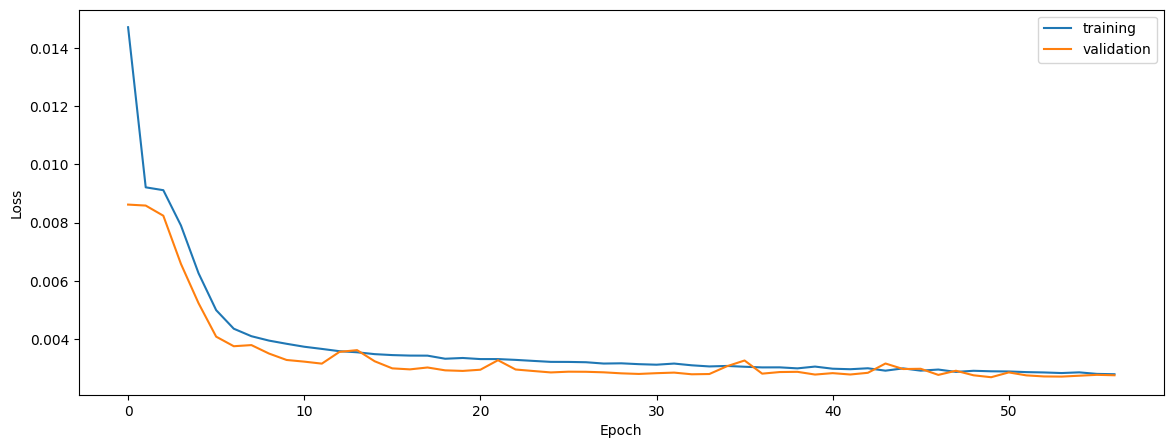

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8342185991930935
0.8291758816753395
0.8186908734737328


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8349220417744997
0.8454683521863345
0.8255006521063386


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8334614214180593
0.8418441437943119
0.823176022175966


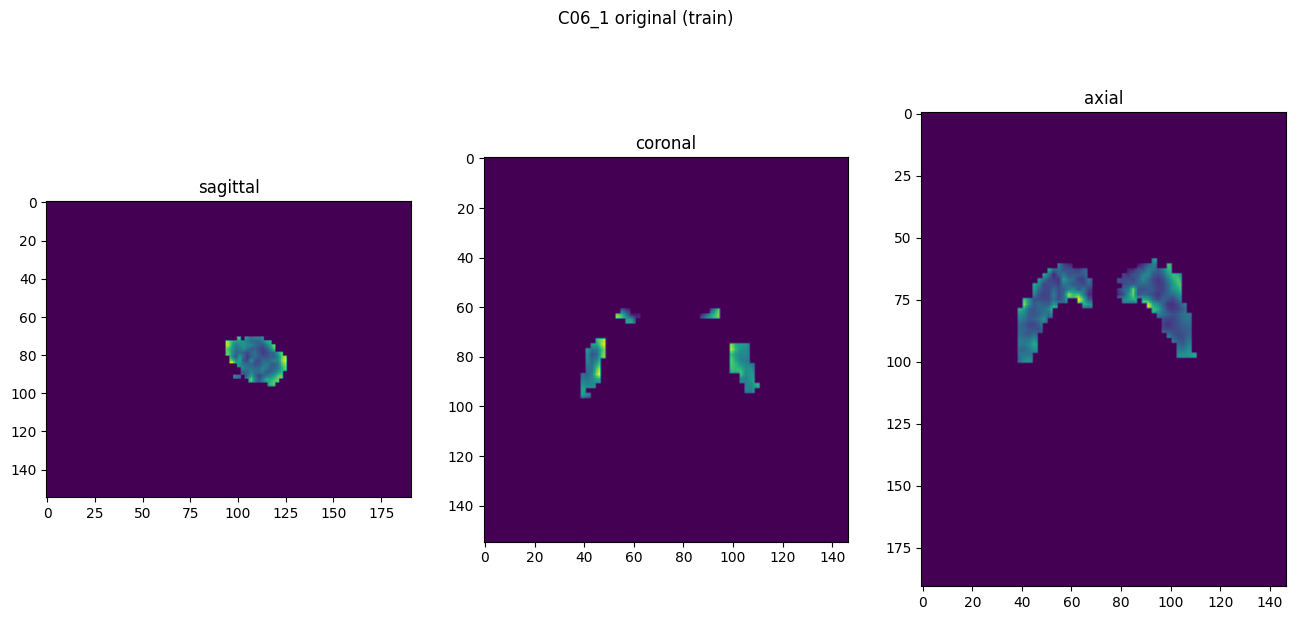

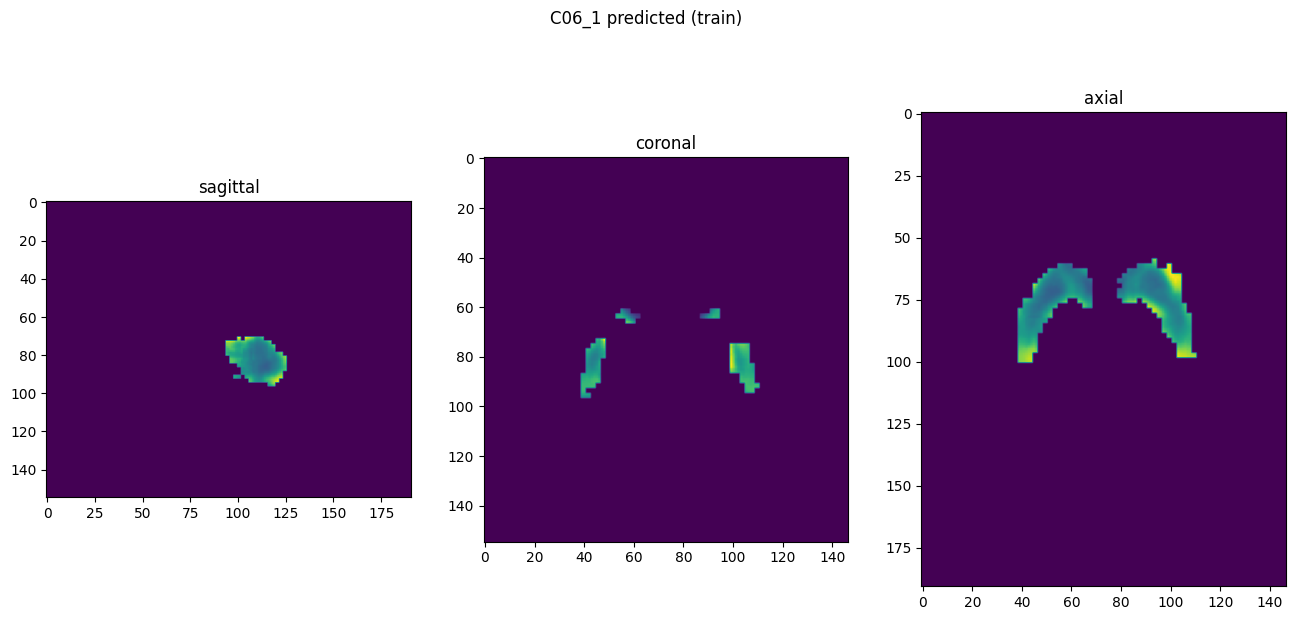

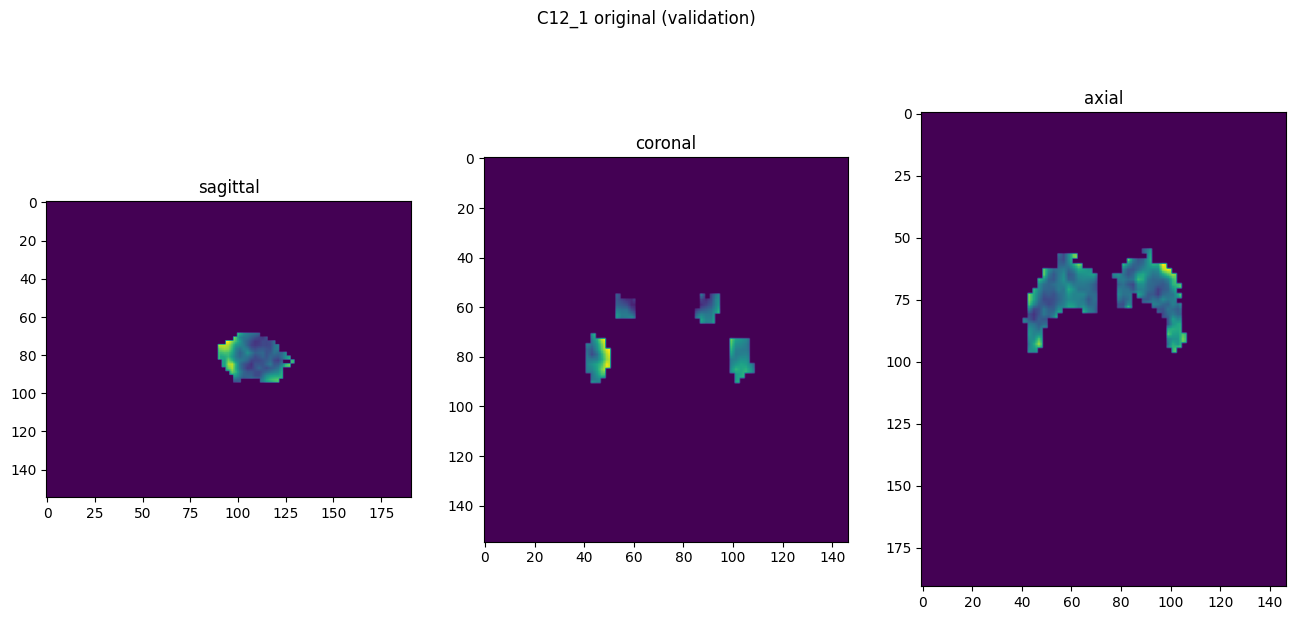

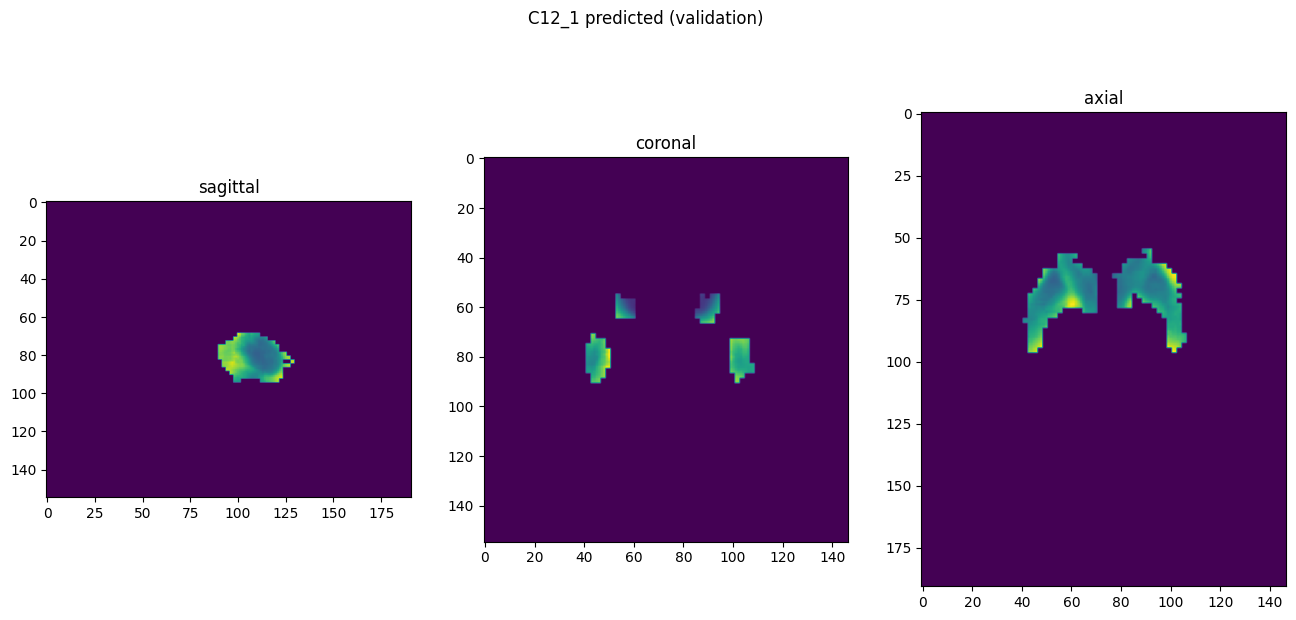

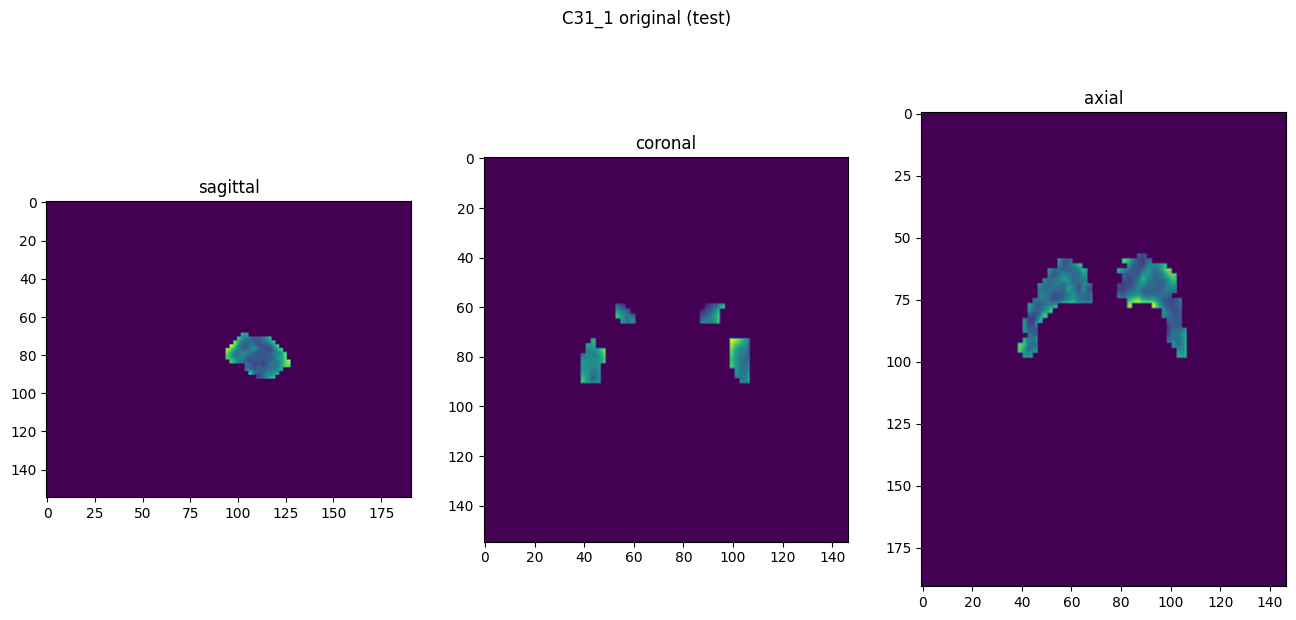

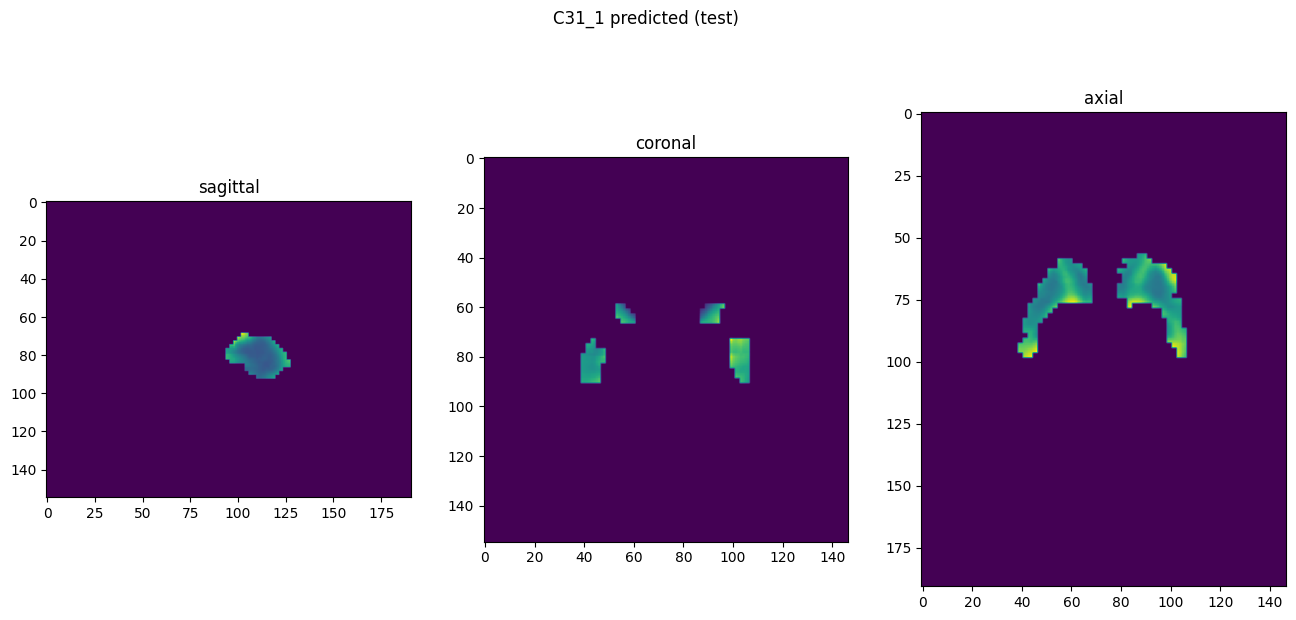

In [10]:
showResults(model, gen, threshold=None, background=False)